### Try Canny Edge Detection

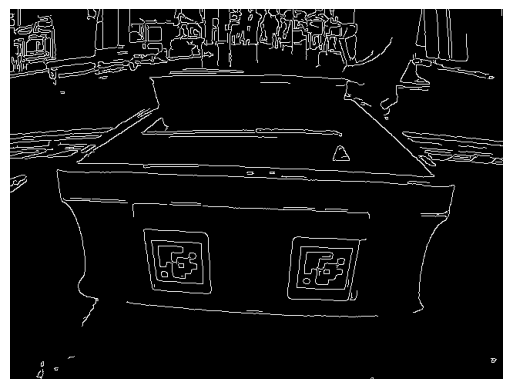

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to perform the operations
def find_bounding_boxes(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth the image and reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop over the contours
    for contour in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # The contour is considered a rectangle if it has 4 vertices
        if len(approx) == 4:
            # Compute the bounding box of the contour and draw it on the image
            (x, y, w, h) = cv2.boundingRect(approx)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the output image
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

# Call the function with the path to your image
path = "dataset/may15_run00_cam07/frame_500.png"
find_bounding_boxes(path)

### Running yolov8 directly

In [1]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Load a model
model = YOLO("yolov8n.pt")

In [2]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

The feature names do not contain a box feature, but we can still check if it can detect the klt successfully.


0: 480x640 4 persons, 1 bench, 108.4ms
Speed: 4.1ms preprocess, 108.4ms inference, 1201.5ms postprocess per image at shape (1, 3, 480, 640)


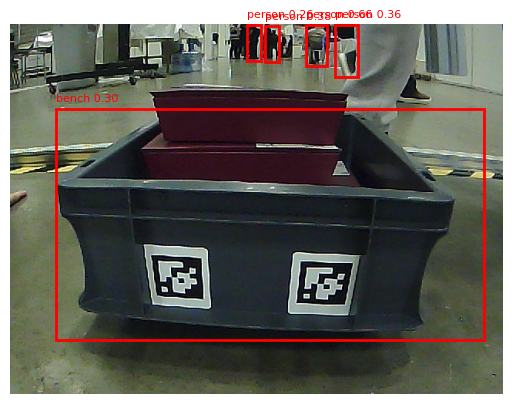

In [3]:
# Load the image using PIL
path = "dataset/may15_run00_cam07/frame_500.png"
image = Image.open(path)

# Perform object detection on the image
results = model.predict(source=image)

# Extract bounding boxes, classes, names, and confidences
boxes = results[0].boxes.xyxy.tolist()
classes = results[0].boxes.cls.tolist()
names = results[0].names
confidences = results[0].boxes.conf.tolist()

# Convert PIL image to array for matplotlib
image_np = np.array(image)

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image_np)

# Iterate through the results and add bounding boxes to the image
for box, cls, conf in zip(boxes, classes, confidences):
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 10, f"{names[int(cls)]} {conf:.2f}", color='red', fontsize=8)

# Display the image
plt.axis('off')  # Turn off axis
plt.show()

In [5]:
# Iterate through the results and print them
for box, cls, conf in zip(boxes, classes, confidences):
    print(f"Class: {names[int(cls)]}, Confidence: {conf:.2f}, Bounding box: {box}")

Class: person, Confidence: 0.66, Bounding box: [383.6820373535156, 0.0, 411.7855529785156, 53.86298370361328]
Class: person, Confidence: 0.38, Bounding box: [330.2887268066406, 2.033428192138672, 348.6337585449219, 48.40275573730469]
Class: person, Confidence: 0.36, Bounding box: [422.0479736328125, 0.0, 451.4520263671875, 68.19823455810547]
Class: bench, Confidence: 0.30, Bounding box: [59.3331298828125, 108.94435119628906, 615.1873168945312, 409.40869140625]
Class: person, Confidence: 0.26, Bounding box: [307.3621826171875, 0.3527183532714844, 325.246337890625, 46.793785095214844]


This confidence level is not significant and it identifies the person incorrectly, so exploring custom training is a good idea.

Inference time about 100ms should be sufficient for our use case.